In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
def create_graph(edges):
    # Create an undirected graph
    graph = nx.Graph()

    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def set_upper_bounds(graph):
    upper_bounds = {}

    # Get user input for upper degree constraints
    for node in graph.nodes():
        while True:
            try:
                upper_bound = int(input(f"Enter upper degree constraint for node {node}: "))
                if upper_bound >= 0:
                    upper_bounds[node] = upper_bound
                    break
                else:
                    print("Please enter a non-negative integer.")
            except ValueError:
                print("Invalid input. Please enter a valid integer.")

    return upper_bounds

def calculate_delta(graph, upper_bounds):
    delta_values = {}

    # Calculate delta for each vertex
    for node in graph.nodes():
        degree = graph.degree(node)
        upper_bound = upper_bounds[node]
        delta = degree - upper_bound
        delta_values[node] = delta

    return delta_values

def create_bipartite_graph(node, delta, degree, grp, graph_dict):

    bipartite_graph = nx.Graph()

    # Add nodes to the first class
    # range starts from node value to node+delta value
    
    delta_node_names = []
    
    for i in range(0, delta):
        if i != 0:
            delta_node_name = str(node) + "." + str(i)
            delta_node_names.append(delta_node_name)
        else:
            delta_node_names.append(node)
    
    bipartite_graph.add_nodes_from(delta_node_names, bipartite=0)


    # Add nodes to the second class
    bipartite_graph.add_nodes_from(graph_dict[str(node)], bipartite=1)

    # Add edges between nodes of opposite classes
    bipartite_graph.add_edges_from([(delta_node, degree_node) for delta_node in delta_node_names for degree_node in graph_dict[str(node)]])
    
    #getting edges from eact subgraphs
    for primary_edge, secondary_edge in bipartite_graph.edges():
        # checking subgraph edges is same as individual node value
        if primary_edge == node:
            # created edges for entire graph 
            edge = (primary_edge, int(str(node) + str(secondary_edge)))
        else:
            # created edges for entire graph 
            edge = (primary_edge, int(str(node) + str(secondary_edge)))
            
        #appending edges
        grp.append(edge)
    return (bipartite_graph, node)


def display_all_bipartite_graphs(bipartite_graphs):
    
    plt.figure(figsize=(12, 8))
    
    for i, (bipartite_graph, node) in enumerate(bipartite_graphs):
        plt.subplot(2, 3, i + 1)
        pos = nx.spring_layout(bipartite_graph)
        nx.draw(bipartite_graph, pos, with_labels=True, font_weight='bold', node_color=['skyblue' if bipartite == 0 else 'lightcoral' for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()], node_size=500, edgecolors='black', linewidths=1.0)
        plt.title(f"Bipartite Graph for Node {node}")

    plt.tight_layout()
    plt.show()

In [7]:
# Create the graph
original_graph = [(1,2),(2,3),(3,4),(4,1),(4,2)]
my_graph = create_graph(original_graph)

# Making dictionary for other purpose
graph_dict = {}

for edge in original_graph:
    graph_dict.setdefault(str(edge[0]), []).append(edge[1])
    graph_dict.setdefault(str(edge[1]), []).append(edge[0])

# Convert values to sets to remove duplicate neighbors
graph_dict = {key: list(set(value)) for key, value in graph_dict.items()}


# for edges in my_graph.edges():
#     grp.append(edges)

# Get user input for upper degree constraints
upper_bounds_dict = set_upper_bounds(my_graph)

# Set upper bounds as node attributes
nx.set_node_attributes(my_graph, upper_bounds_dict, 'upper_bound')

# Print the graph with upper degree constraints
print("Graph with Upper Degree Constraints:")
print(my_graph.nodes(data=True))

# Calculate delta values for each vertex
delta_values_dict = calculate_delta(my_graph, upper_bounds_dict)

# Print the delta values for each vertex
print("\nDelta Values:")
print(delta_values_dict)

Enter upper degree constraint for node 1: 1
Enter upper degree constraint for node 2: 2
Enter upper degree constraint for node 3: 1
Enter upper degree constraint for node 4: 2
Graph with Upper Degree Constraints:
[(1, {'upper_bound': 1}), (2, {'upper_bound': 2}), (3, {'upper_bound': 1}), (4, {'upper_bound': 2})]

Delta Values:
{1: 1, 2: 1, 3: 1, 4: 1}


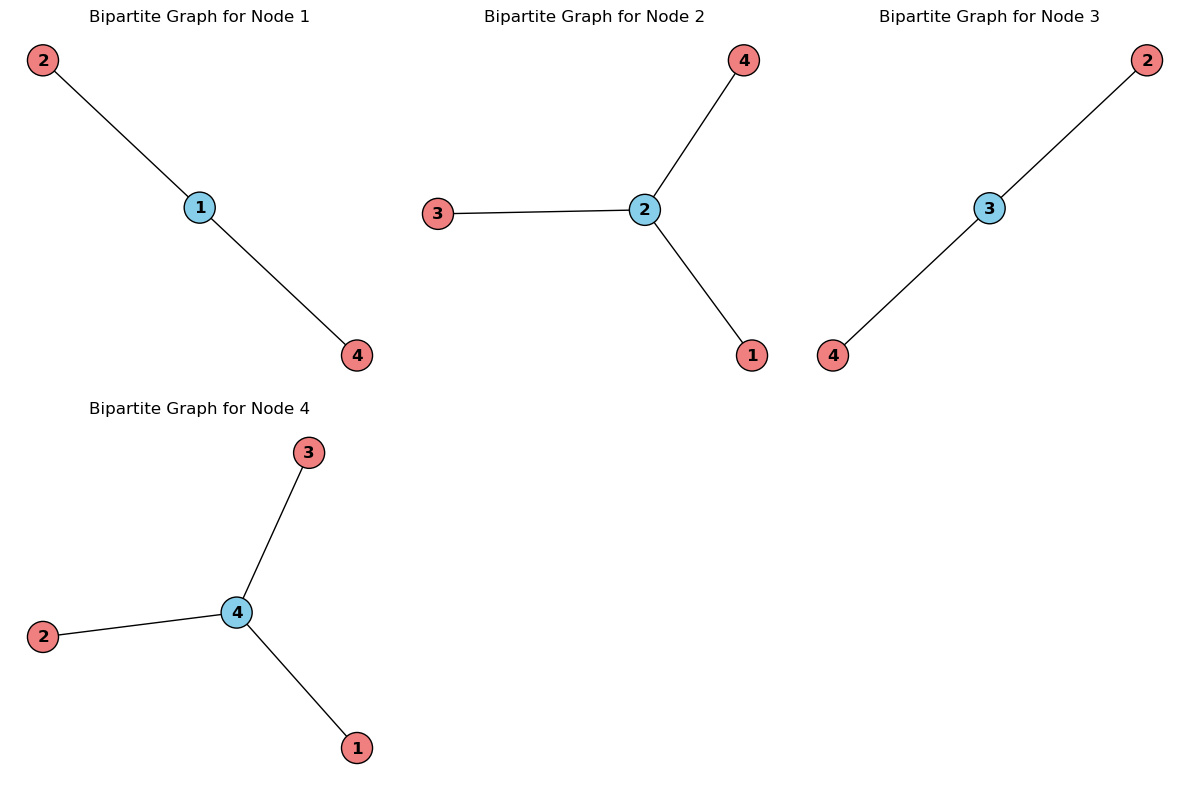

In [8]:
# list to combine edges from original and sub graphs
grp = []

# Create bipartite graphs for each vertex
bipartite_graphs = [create_bipartite_graph(node, 
                                           delta_values_dict[node], 
                                           my_graph.degree(node), 
                                           grp,
                                           graph_dict) for node in my_graph.nodes()]

# Display individual bipartite graphs
display_all_bipartite_graphs(bipartite_graphs)

In [9]:


# Create a dictionary to store mappings
mapping_bipartite_graph = []

rev_nodes = []

# Iterate through the list to build mappings
for node1, node2 in grp:
    rev_node = int(str(node2)[::-1])
    edge_set = (node2, rev_node)
    if rev_node not in rev_nodes:
        if edge_set not in mapping_bipartite_graph:
            mapping_bipartite_graph.append((node2, rev_node))
            rev_nodes.append(rev_node)
            rev_nodes.append(node2)


for edges in mapping_bipartite_graph:
    grp.append(edges)
    
print(grp)

[(1, 12), (1, 14), (2, 21), (2, 23), (2, 24), (3, 32), (3, 34), (4, 41), (4, 42), (4, 43), (12, 21), (14, 41), (23, 32), (24, 42), (34, 43)]


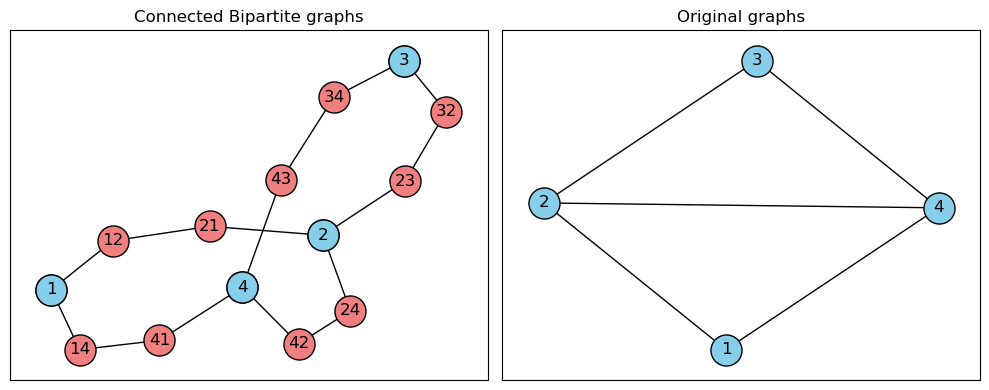

In [11]:


# Display the graph with connected bipartite subgraphs
com_graph = create_graph(grp)

pos_combined = nx.spring_layout(com_graph)

org_graph = nx.spring_layout(my_graph)

sub_graph_edges = []
delta_list = []


for edge in com_graph.edges():
    if edge not in my_graph.edges():
        sub_graph_edges.append(edge)
    
for node in com_graph.nodes():
    if isinstance(node, str):
        delta_list.append(node)


# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot data in the first subplot (axes[0])
nx.draw_networkx_nodes(com_graph, pos_combined, node_size=500, node_color= 'lightcoral', edgecolors='black', linewidths=1.0, ax = axes[0])
nx.draw_networkx_nodes(com_graph, pos_combined, nodelist = my_graph.nodes(),  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0, ax = axes[0])
nx.draw_networkx_nodes(com_graph, pos_combined, nodelist = delta_list,  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0, ax = axes[0])
nx.draw_networkx_edges(com_graph, pos_combined, edgelist=sub_graph_edges, edge_color='black', ax = axes[0])
nx.draw_networkx_labels(com_graph, pos_combined, font_size=12, font_color='black', ax = axes[0])
axes[0].set_title('Connected Bipartite graphs')
# axes[0].legend()

# Plot data in the second subplot (axes[1])
nx.draw_networkx_nodes(my_graph, org_graph,  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0, ax = axes[1])
nx.draw_networkx_edges(my_graph, org_graph, edge_color='black', ax = axes[1])
nx.draw_networkx_labels(my_graph, org_graph, font_size=12, font_color='black', ax = axes[1])
axes[1].set_title('Original graphs')
# axes[1].legend()


plt.tight_layout()

plt.show()

In [ ]:
# Example usage:
matching = nx.algorithms.matching.max_weight_matching(com_graph, maxcardinality=False)
print("Matching:", matching)